In [4]:
import hoomd
import hoomd.md
from matplotlib import pyplot
%matplotlib inline

# Tuning neighbor list parameters

There are a number of parameters to the neighbor list that influence the performance of the simulation but not the correctness. The buffer radius ``r_buff`` controls how many extra neighbors are included in the list. The larger ``r_buff``, the less off the list is rebuilt, but the more extra force computations are necessary. When ``r_buff`` is small, the nlist is built more often, but there are fewer extra forces. These two competing effects yield an optimal value for ``r_buff``. You cannot predict the optimal performing ``r_buff``, you need to benchmark it as it depends strongly on your model, parameters, and hardware.

Here is a simple 3D lj fluid model to demonstrate nlist tuning.

In [2]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]            Tesla K20c  13 SM_3.5 @ 0.706 GHz, 5092 MiB DRAM
notice(2): Group "all" created containing 1000 particles
notice(2): integrate.langevin/bd is using specified gamma values


## Tune r_buff

HOOMD has a builtin method to tune the optimal ``r_buff`` value.

In [3]:
nl.tune(warmup=20000, r_min=0.05, r_max=1.55, jumps=11, steps=5000, set_max_check_period=False)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 20000 / 20000 | TPS 6347.48 | ETA 00:00:00
Average TPS: 6342.59
---------
-- Neighborlist stats:
1854 normal updates / 68 forced updates / 0 dangerous updates
n_neigh_min: 75 / n_neigh_max: 94 / n_neigh_avg: 86.182
shortest rebuild period: 8
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 32 / n_max: 43 / n_avg: 37.037
** run complete **
** starting run **
Time 00:00:04 | Step 25000 / 25000 | TPS 4834.92 | ETA 00:00:00
Average TPS: 4829.72
---------
-- Neighborlist stats:
2524 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 51 / n_neigh_max: 66 / n_neigh_avg: 58.684
shortest rebuild period: 1
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 12 / n_max: 19 / n_avg: 15.625
** run complete **
** starting r

(1.1, 23)

The resulting performance vs r_buff curve looks like this.

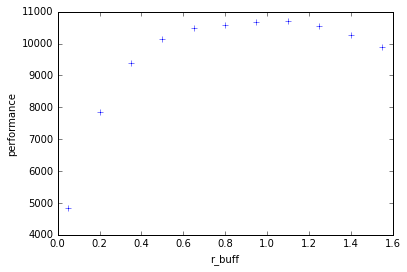

In [7]:
pyplot.plot([0.05, 0.2, 0.35, 0.49999999999999994, 0.65, 0.8, 0.95, 1.1, 1.25, 1.4, 1.55], [4829.723276175168, 7856.706248752748, 9388.825044878584, 10131.404313951958, 10472.980756945157, 10589.271796957068, 10681.843429811744, 10708.885376374485, 10561.669588728586, 10257.104583489754, 9902.029321889228], '+')
pyplot.xlabel('r_buff')
pyplot.ylabel('performance')

Tune r_buff in a few test simulations at the range of parameters you intend to explore. Then set a static r_buff in your production simulations.

In [8]:
nl.set_params(r_buff = 1.1, check_period=23)
hoomd.run(5000)

** starting run **
Time 00:03:32 | Step 210000 / 210000 | TPS 11517.2 | ETA 00:00:00
Average TPS: 11482.8
---------
-- Neighborlist stats:
132 normal updates / 17 forced updates / 0 dangerous updates
n_neigh_min: 157 / n_neigh_max: 179 / n_neigh_avg: 166.836
shortest rebuild period: 24
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 120 / n_max: 132 / n_avg: 125
** run complete **


## Use a different acceleration structure

HOOMD provides 3 types of acceleration structures for neighbor lists. The cell list (consider this the default), the stenciled cell list, and the tree data structure. See [the nlist documentation](http://hoomd-blue.readthedocs.io/en/stable/module-md-nlist.html) for more information. This example just demonstrates how to enable the different acceleration structures.

### Stencil cell list

In [9]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.stencil(r_buff = 1.1, cell_width = 1.8)
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): Group "all" created containing 1000 particles
-----
You are using stenciled neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----
notice(2): integrate.langevin/bd is using specified gamma values


In [10]:
hoomd.run(5000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:09 | Step 5000 / 5000 | TPS 3897.64 | ETA 00:00:00
Average TPS: 3890.96
---------
-- Neighborlist stats:
131 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 153 / n_neigh_max: 180 / n_neigh_avg: 167.004
shortest rebuild period: 23
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 5 / n_max: 11 / n_avg: 8
** run complete **


To fully evaluate the performance of the stencil cell list, tune the ``cell_width`` and ``r_buff``.

### Tree

In [11]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.tree(r_buff = 1.1)
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): Group "all" created containing 1000 particles
-----
You are using tree neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----
notice(2): integrate.langevin/bd is using specified gamma values


In [12]:
hoomd.run(5000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 5000 / 5000 | TPS 2581.54 | ETA 00:00:00
Average TPS: 2580.06
---------
-- Neighborlist stats:
132 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 155 / n_neigh_max: 179 / n_neigh_avg: 166.81
shortest rebuild period: 23
** run complete **
